In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import StratifiedShuffleSplit

from utils import split_data
from datasetConstruct import CustomDataset, load_seizure
from models import CNN1D, train_using_optimizer, Wavenet, LSTM, evaluate_model

data_folder = "data"
MODEL_FOLDER = "checkpoints"
PAT_NO = 66

In [2]:
data_folder = os.path.join(data_folder, f"P{PAT_NO}")
seizure = load_seizure(data_folder)

In [3]:
# Divide the seizure and nonseizure data in to 1s windows
window_size = 1
fs = seizure.samplingRate

seizure_data = seizure.ictal
nonseizure_data = seizure.interictal
nonseizure_data_postictal = seizure.postictal
# 
# seizure_data = split_data(seizure_data, fs)
# nonseizure_data = split_data(nonseizure_data, fs)
# nonseizure_data_postictal = split_data(nonseizure_data_postictal, fs)


In [4]:
train_percentage = 0.8

# Combine the nonseizure and postictal data
nonseizure_data = np.concatenate((nonseizure_data, nonseizure_data_postictal), axis=0)

# Flatten the train dataset from [Sample, Time, Channel] to [Sample * Channel, Time, 1]
seizure_data = seizure_data.reshape(-1, seizure_data.shape[1], 1)
nonseizure_data = nonseizure_data.reshape(-1, seizure_data.shape[1], 1)

# Create the labels
seizure_labels = np.ones(len(seizure_data))
nonseizure_labels = np.zeros(len(nonseizure_data))

seizure_data = seizure_data.transpose(0, 2, 1)
nonseizure_data = nonseizure_data.transpose(0, 2, 1)

# Combine the dataset and labels, then shuffle them and create training and validation sets
data = np.concatenate((seizure_data, nonseizure_data), axis=0)
labels = np.concatenate((seizure_labels, nonseizure_labels), axis=0)

# Shuffle the data
shuffled_indices = np.random.permutation(len(data))
data = data[shuffled_indices]
labels = labels[shuffled_indices]

# Create a subset of the data for balanced dataset
seizure_indices = np.where(labels == 1)[0]
nonseizure_indices = np.where(labels == 0)[0]

n_samples = min(len(seizure_indices), len(nonseizure_indices))
seizure_indices = np.random.choice(seizure_indices, n_samples, replace=False)
nonseizure_indices = np.random.choice(nonseizure_indices, n_samples, replace=False)

data = np.concatenate((data[seizure_indices], data[nonseizure_indices]), axis=0)
labels = np.concatenate((labels[seizure_indices], labels[nonseizure_indices]), axis=0)

# Use stratified sampling to create the training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-train_percentage, random_state=0)
for train_index, val_index in sss.split(data, labels):
    train_data, val_data = data[train_index], data[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

channels = 1
time_steps = train_data.shape[2]


In [98]:
from datasetConstruct import create_dataset
train_loader1, val_loader1 = create_dataset(seizure, train_percentage=0.8, batch_size=512)

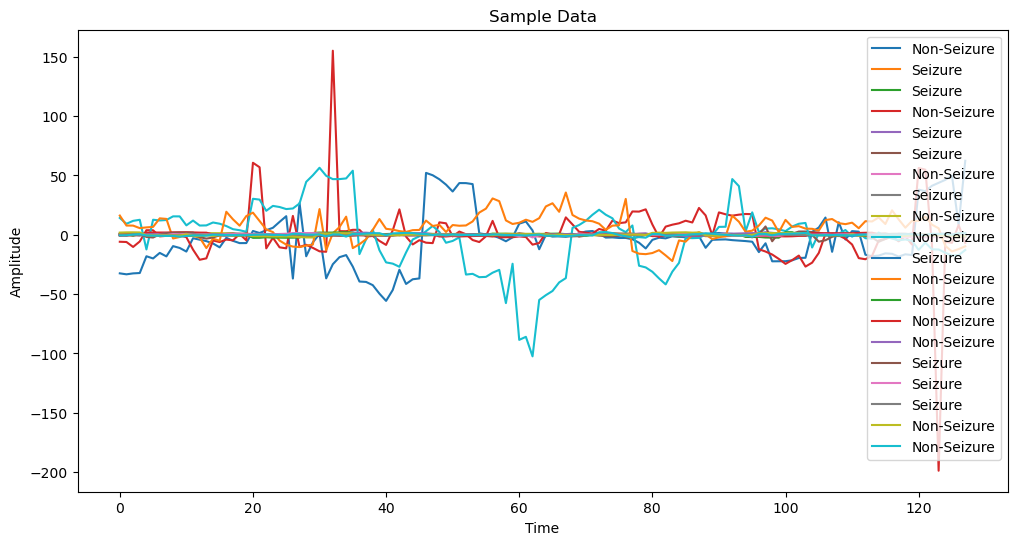

In [5]:
# Select random samples from the dataset to visualize
n_samples = 20
sample_indices = np.random.choice(len(data), n_samples, replace=False)
sample_labels = labels[sample_indices]
sample_data = data[sample_indices]
# Plot the samples

plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(sample_data[i, 0, :], label=f"Seizure" if sample_labels[i] == 1 else "Non-Seizure")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sample Data")
plt.legend()
plt.show()


In [8]:
# Load the dataset
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)


In [9]:
# Create the model
epochs = 10
checkpoint_freq = 5
lr = 0.001 # DO NOT CHANGE!
TRAIN = True

model1 = CNN1D(input_dim=channels, kernel_size=time_steps, output_dim=2, lr=lr)
model2 = Wavenet(input_dim=channels, output_dim=2, kernel_size=time_steps, lr=lr)
model3 = LSTM(input_dim=channels, output_dim=2, lr=lr)

if TRAIN:

    # Train the model
    CNNtrain_loss, CNNval_los, CNNval_accuracy = train_using_optimizer(
                                                                        model=model1,
                                                                        trainloader=train_loader,
                                                                        valloader=val_loader,
                                                                        save_location='checkpoints',
                                                                        epochs=epochs,
                                                                        device='cuda:0',
                                                                        patience=7,
                                                                        gradient_clip=1.0,
                                                                        checkpoint_freq=checkpoint_freq
                                                                    )
    
    Wavetrain_loss, Waveval_los, Waveval_accuracy = train_using_optimizer(
                                                                            model=model2,
                                                                            trainloader=train_loader,
                                                                            valloader=val_loader,
                                                                            save_location='checkpoints',
                                                                            epochs=epochs,
                                                                            device='cuda:0',
                                                                            patience=7,
                                                                            gradient_clip=1.0,
                                                                            checkpoint_freq=checkpoint_freq
                                                                        )
    LSTMtrain_loss, LSTMval_los, LSTMval_accuracy = train_using_optimizer(
                                                                            model=model3,
                                                                            trainloader=train_loader,
                                                                            valloader=val_loader,
                                                                            save_location='checkpoints',
                                                                            epochs=epochs,
                                                                            device='cuda:0',
                                                                            patience=7,
                                                                            gradient_clip=1.0,
                                                                            checkpoint_freq=checkpoint_freq
                                                                        )
    
else:
    # Load the model
    model1.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "CNN1D_best.pth")))
    model2.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "Wavenet_best.pth")))
    model3.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "LSTM_best.pth")))

# Evaluate the model
loss_CNN, acuracy_CNN = evaluate_model(model1, val_loader,'cuda:0')
loss_LSTM, acuracy_LSTM = evaluate_model(model3, val_loader,'cuda:0')
loss_Wavenet, acuracy_Wavenet = evaluate_model(model2, val_loader,'cuda:0')

Epoch 5/10: 100%|██████████| 263/263 [00:07<00:00, 37.54it/s, loss=0.3832, avg_loss=0.3664]


Epoch [5/10]
Training Loss: 0.3664
Validation Loss: 0.3650
Validation Accuracy: 0.9449


Epoch 10/10: 100%|██████████| 263/263 [00:06<00:00, 37.65it/s, loss=0.3602, avg_loss=0.3456]


Epoch [10/10]
Training Loss: 0.3456
Validation Loss: 0.3403
Validation Accuracy: 0.9724


Epoch 5/10: 100%|██████████| 263/263 [00:06<00:00, 38.14it/s, loss=0.3555, avg_loss=0.3547]


Epoch [5/10]
Training Loss: 0.3547
Validation Loss: 0.3490
Validation Accuracy: 0.9627


Epoch 10/10: 100%|██████████| 263/263 [00:07<00:00, 37.35it/s, loss=0.3251, avg_loss=0.3442]


Epoch [10/10]
Training Loss: 0.3442
Validation Loss: 0.3374
Validation Accuracy: 0.9751


Epoch 1/10:   0%|          | 1/263 [00:00<01:57,  2.22it/s]Error in training batch 1: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 2: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 3: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 4: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 5: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 6: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 7: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Epoch 1/10:   3%|▎         | 8/263 [00:00<00:14, 18.01it/s]Error in training batch 8: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 9: mat1 and mat2 shapes cannot be multiplied (512x1024 and 184x2)
Error in training batch 10: mat1 and mat2 shapes cannot be multiplied (5

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\arthu\anaconda3\envs\Code\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\arthu\AppData\Local\Temp\ipykernel_170596\1135347089.py", line 56, in <module>
    loss_LSTM, acuracy_LSTM = evaluate_model(model3, val_loader,'cuda:0')
  File "D:\BlcRepo\LabCode\SeizureProp\models.py", line 581, in evaluate_model
ValueError: No valid samples processed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\arthu\anaconda3\envs\Code\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\arthu\anaconda3\envs\Code\lib\site-packages\IPython\core\ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\arthu\anaconda3\envs\Code\lib\site-packa

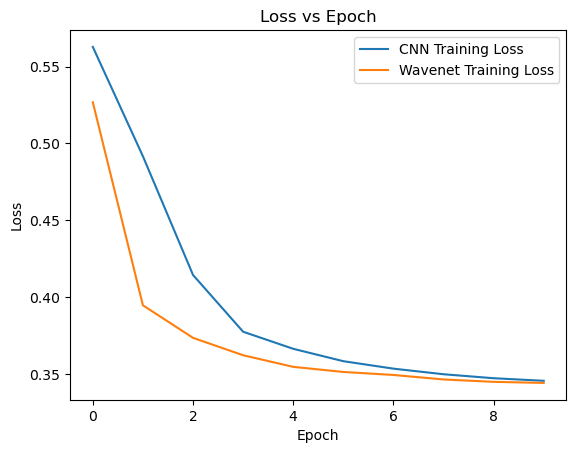

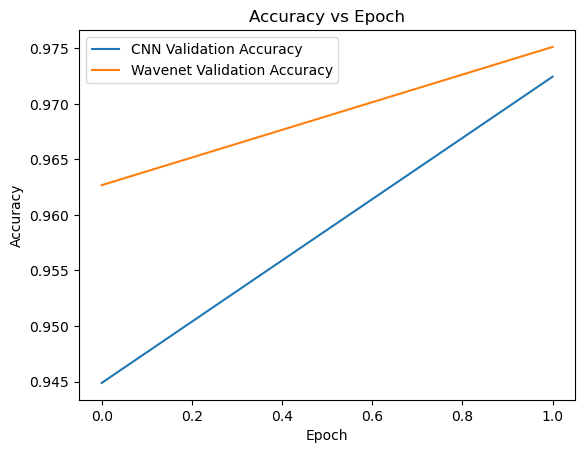

In [10]:
if TRAIN:

    # Plot the loss and accuracy
    
    plt.figure()
    plt.plot(CNNtrain_loss, label="CNN Training Loss")
    # plt.plot(CNNval_los, label="CNN Validation Loss")
    plt.plot(Wavetrain_loss, label="Wavenet Training Loss")
    # plt.plot(Waveval_los, label="Wavenet Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.show()
    
    plt.figure()
    plt.plot(CNNval_accuracy, label="CNN Validation Accuracy")
    plt.plot(Waveval_accuracy, label="Wavenet Validation Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.show()


In [91]:
from datasetConstruct import load_single_seizure
seizure_no = 3
# Get the probability of the all the dataset in a temporal matter
seizure1 = load_single_seizure(data_folder, seizure_no)

In [92]:
from models import output_to_probability
import torch

model = model2
model_name = model.__class__.__name__

seizure1_data = seizure1.ictal
seizure1_preictal = seizure1.preictal2

seizure1_data_combined = seizure1_data.reshape(-1, seizure1_data.shape[2])
seizure1_preictal_combined = seizure1_preictal

seizure1_total_con = np.concatenate((seizure1_preictal_combined, seizure1_data_combined), axis=0)

# Resample the data to 1s windows with 80% overlap
seizure1_total = split_data(seizure1_total_con, fs, overlap=0.8)

probabilities_matrix = np.zeros((seizure1_total.shape[0], seizure1_total.shape[2]))
# probabilities_matrix_preictal = np.zeros((seizure1_preictal.shape[0], seizure1_data.shape[2]))

# Feed the data to the model
for channel in range(seizure1_total.shape[2]):
    input_data = seizure1_total[:, :, channel].reshape(-1, 1, seizure1_total.shape[1])
    input_data = torch.tensor(input_data, dtype=torch.float32).to('cuda:0')
    probabilities_matrix[:, channel] = output_to_probability(model, input_data, 'cuda:0')
    # for trial in range(seizure1_preictal.shape[0]):
    #     input_data = seizure1_preictal[trial, :, channel].reshape(-1, 1, seizure1_preictal.shape[1])
    #     input_data = torch.tensor(input_data, dtype=torch.float32).to('cuda:0')
    #     probabilities_matrix[trial, channel] = output_to_probability(model1, input_data, 'cuda:0')
    

In [93]:
def plot_time_limited_heatmap(data, time_axis, n_seconds=None, preictal_boundary=None, 
                             title="", cmap='cool', clim=None, save_path=None):
    """
    Plot heatmap with time limitation.
    
    Parameters:
    -----------
    data : numpy.ndarray
        2D array of data to plot
    time_axis : numpy.ndarray
        Time axis values
    n_seconds : float, optional
        Number of seconds to plot (from start)
    preictal_boundary : int, optional
        Index where preictal period ends
    """
    # Calculate the index corresponding to n_seconds
    if n_seconds is not None:
        time_mask = time_axis <= n_seconds
        plot_data = data[:, time_mask]
        plot_time = time_axis[time_mask]
        if preictal_boundary is not None:
            preictal_boundary = min(preictal_boundary, len(plot_time)-1)
    else:
        plot_data = data
        plot_time = time_axis
    
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(plot_time, np.arange(data.shape[0]), plot_data, 
                   cmap=cmap, shading='auto')
    
    if preictal_boundary is not None and preictal_boundary < len(plot_time):
        plt.axvline(x=plot_time[preictal_boundary], color='r', linestyle='--', 
                   label='Preictal Boundary')
    
    # Optimize tick marks
    n_ticks = min(20, len(plot_time))
    tick_indices = np.linspace(0, len(plot_time)-1, n_ticks, dtype=int)
    plt.xticks(plot_time[tick_indices], np.round(plot_time[tick_indices], 2), 
               fontsize=12)
    
    plt.colorbar(label='Amplitude')
    
    if clim is not None:
        plt.clim(clim[0], clim[1])
    
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    plt.title(title)
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        plt.close()

In [94]:
n_seconds = 80

# Create time axes
time_raw = np.arange(0, seizure1_total_con.shape[0]) / fs
time_prob = np.arange(0, probabilities_matrix.shape[0]) * 0.2

# Concatenate data
seizure_total = np.concatenate((seizure1_preictal_combined, 
                              seizure1_data_combined), axis=0)
# prob_total = np.concatenate((probabilities_matrix_preictal, 
#                            probabilities_matrix), axis=0).T

print("Mean of seizure data:", np.mean(seizure1_data_combined))
print("Mean of preictal data:", np.mean(seizure1_preictal_combined))
print("Mean of seizure probability:", np.mean(probabilities_matrix))
# print("Mean of preictal probability:", np.mean(probabilities_matrix_preictal))


# Plot raw data
plot_time_limited_heatmap(
    data=seizure_total.T,
    time_axis=time_raw,
    n_seconds=n_seconds,
    preictal_boundary=seizure1_preictal_combined.shape[0],
    title=f"Raw Seizure{seizure_no} Data (First {n_seconds}s)" if n_seconds else "Raw Seizure Data",
    cmap='cool',
    clim=(-0.1, 0.1),
    save_path=f"result/Seizure{seizure_no}RawData.png"
)

# Plot probability data
plot_time_limited_heatmap(
    data=probabilities_matrix.T,
    time_axis=time_prob,
    n_seconds=n_seconds,
    preictal_boundary=50,
    title=f"{model_name} " + f"Probability of Seizure{seizure_no} (First {n_seconds}s)" if n_seconds else "Probability of Seizure",
    cmap='hot',
    save_path=f"result/Seizure{seizure_no}{model_name}Probability.png"
)

Mean of seizure data: -0.00017343149228095278
Mean of preictal data: -0.0004935252848965425
Mean of seizure probability: 0.7461475682907828


In [95]:
# Rerank the Probability Based on the when the channel first reach the threshold
threshold = 0.6
# Smooth the probability data over 2 seconds, each tick is 0.2s
smooth_window = 50
n_seconds = 80

# Smooth the probability data
probabilities_matrix_smoothed = np.zeros_like(probabilities_matrix)
for i in range(probabilities_matrix.shape[1]):
    probabilities_matrix_smoothed[:, i] = np.convolve(probabilities_matrix[:, i], 
                                                       np.ones(smooth_window) / smooth_window, 
                                                       mode='same')

sub_probability = probabilities_matrix_smoothed[: 4000, :]
    
# Find the first index where the probability is greater than the threshold
first_threshold_indices = np.argmax(probabilities_matrix_smoothed > threshold, axis=0)
if np.sum(first_threshold_indices == 0) > 0:
    first_threshold_indices[first_threshold_indices == 0] = len(probabilities_matrix_smoothed)
sorted_indices = np.argsort(first_threshold_indices)[::-1]

# # Sort the channels based on the number of ticks to reach the threshold
# number_of_ticks_each_channel = np.zeros(sub_probability.shape[1])
# for i in range(sub_probability.shape[1]):
#     number_of_ticks_each_channel[i] = np.sum(sub_probability[:, i] > threshold)
#     sorted_indices = np.argsort(number_of_ticks_each_channel)

# # Sort the channels based on the mean probability
# mean_probabilities = np.mean(sub_probability, axis=0)
# sorted_indices = np.argsort(mean_probabilities)

# Plot the probability data
plot_time_limited_heatmap(
    data=probabilities_matrix_smoothed[:, sorted_indices].T,
    time_axis=time_prob,
    n_seconds=n_seconds,
    preictal_boundary=50,
    title=f"{model_name} " + f"Probability of Seizure{seizure_no} (First {n_seconds}s) - Reranked",
    cmap='hot',
    save_path=f"result/Seizure{seizure_no}{model_name}ProbabilityReranked.png"
)

In [86]:
np.min(probabilities_matrix_smoothed)

0.0